In [1]:
# Re-import numpy as it seems it was not detected
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
# Re-running the previous steps to ensure the numpy library is recognized
amr_data = pd.read_csv("final_AMR_data.csv")
gdp_data = pd.read_csv("gdp_data.csv")
health_expenditure = pd.read_csv("health_expenditure.csv")


In [3]:
# Display the first few rows and general information for each dataset
datasets_info = {
    "AMR Data": amr_data.head(),
    "AMR Data Info": amr_data.info(),
    "GDP Data": gdp_data.head(),
    "GDP Data Info": gdp_data.info(),
    "Health Expenditure Data": health_expenditure.head(),
    "Health Expenditure Info": health_expenditure.info()
}

datasets_info['AMR Data'], datasets_info['GDP Data'], datasets_info['Health Expenditure Data']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16829 entries, 0 to 16828
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         16829 non-null  int64  
 1   HealthTopic                                        16829 non-null  object 
 2   Bacteria                                           16829 non-null  object 
 3   Drug_Class                                         16829 non-null  object 
 4   Year                                               16829 non-null  int64  
 5   geo                                                16829 non-null  object 
 6   RegionName                                         16829 non-null  object 
 7   Completeness age_%                                 0 non-null      float64
 8   Completeness gender_%                              0 non-null      float64
 9   I - 's

(   Unnamed: 0               HealthTopic            Bacteria       Drug_Class   
 0           0  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides  \
 1           1  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
 2           2  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
 3           3  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
 4           4  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
 
    Year geo RegionName  Completeness age_%  Completeness gender_%   
 0  2012  AT    Austria                 NaN                    NaN  \
 1  2012  BE    Belgium                 NaN                    NaN   
 2  2012  BG   Bulgaria                 NaN                    NaN   
 3  2012  CY     Cyprus                 NaN                    NaN   
 4  2012  CZ    Czechia                 NaN                    NaN   
 
    I - 'susceptible, increased exposure' isolates _N   
 0                               

In [4]:
# Merge the datasets on 'Year' and 'geo' keys again
merged_data = pd.merge(amr_data, gdp_data, on=['Year', 'geo'], how='inner')
merged_data = pd.merge(merged_data, health_expenditure, on=['Year', 'geo'], how='inner')

# Since we will drop columns with a high percentage of nulls, let's identify them
null_percentage = merged_data.isnull().mean() * 100
columns_to_drop = null_percentage[null_percentage > 50].index.tolist()

# Drop columns with more than 50% missing values
merged_data_clean = merged_data.drop(columns=columns_to_drop)

# Convert percentages from strings to numeric and handle missing values
percent_columns = [col for col in merged_data_clean.columns if '%' in col]
for col in percent_columns:
    merged_data_clean[col] = pd.to_numeric(
        merged_data_clean[col].str.replace('%', ''), errors='coerce'
    )

# Fill remaining missing values with median for numeric columns
numeric_columns = merged_data_clean.select_dtypes(include=[np.number]).columns
merged_data_clean[numeric_columns] = merged_data_clean[numeric_columns].fillna(merged_data_clean[numeric_columns].median())

# Check the first few rows of the cleaned dataset and show information
merged_data_clean_info = merged_data_clean.info()
merged_data_clean_head = merged_data_clean.head()

merged_data_clean_head, merged_data_clean_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9060 entries, 0 to 9059
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0_x                                       9060 non-null   int64  
 1   HealthTopic                                        9060 non-null   object 
 2   Bacteria                                           9060 non-null   object 
 3   Drug_Class                                         9060 non-null   object 
 4   Year                                               9060 non-null   int64  
 5   geo                                                9060 non-null   object 
 6   RegionName                                         9060 non-null   object 
 7   I - 'susceptible, increased exposure' isolates _N  9060 non-null   float64
 8   R - resistant isolates_N                           9060 non-null   float64
 9   R - resi

(   Unnamed: 0_x               HealthTopic               Bacteria   
 0             0  Antimicrobial resistance     Acinetobacter spp.  \
 1           328  Antimicrobial resistance     Acinetobacter spp.   
 2           656  Antimicrobial resistance     Acinetobacter spp.   
 3          1312  Antimicrobial resistance     Acinetobacter spp.   
 4          1971  Antimicrobial resistance  Enterococcus faecalis   
 
                                           Drug_Class  Year geo RegionName   
 0                                    Aminoglycosides  2012  AT    Austria  \
 1                                        Carbapenems  2012  AT    Austria   
 2  Combined resistance (fluoroquinolones, aminogl...  2012  AT    Austria   
 3                                   Fluoroquinolones  2012  AT    Austria   
 4                                   Aminopenicillins  2012  AT    Austria   
 
    I - 'susceptible, increased exposure' isolates _N   
 0                                                0.0  \


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

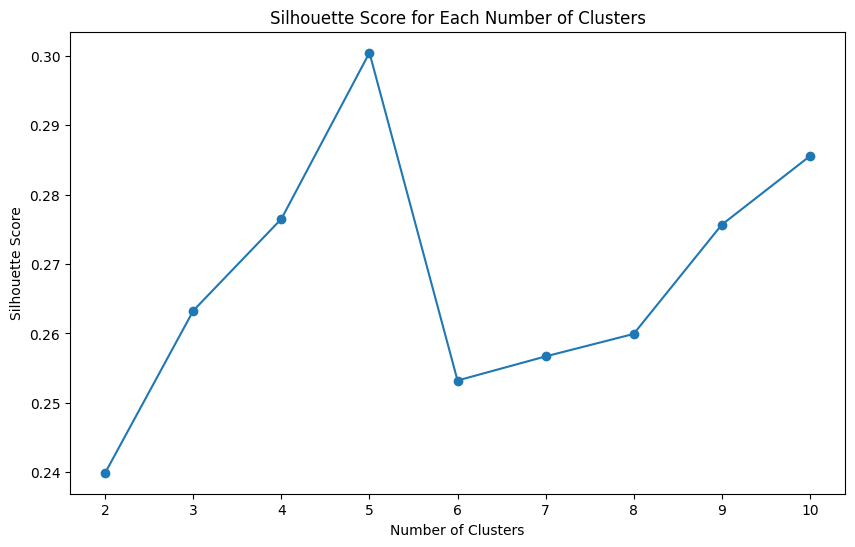

/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xm/zbjsnt8j5sn16bwvmsxbqhmr0000gn/T/ipykernel_19763/3927109858.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bacteria_data['Cluster'] = bacteria_clusters


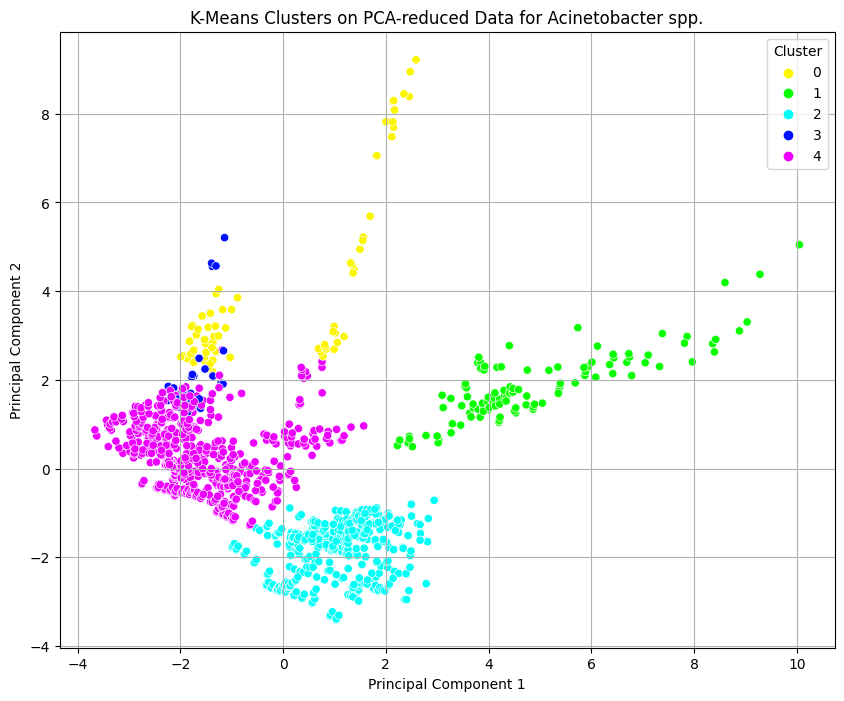

(5,
     Unnamed: 0_x               HealthTopic            Bacteria   
 0              0  Antimicrobial resistance  Acinetobacter spp.  \
 1            328  Antimicrobial resistance  Acinetobacter spp.   
 2            656  Antimicrobial resistance  Acinetobacter spp.   
 3           1312  Antimicrobial resistance  Acinetobacter spp.   
 30             1  Antimicrobial resistance  Acinetobacter spp.   
 
                                            Drug_Class  Year geo RegionName   
 0                                     Aminoglycosides  2012  AT    Austria  \
 1                                         Carbapenems  2012  AT    Austria   
 2   Combined resistance (fluoroquinolones, aminogl...  2012  AT    Austria   
 3                                    Fluoroquinolones  2012  AT    Austria   
 30                                    Aminoglycosides  2012  BE    Belgium   
 
     I - 'susceptible, increased exposure' isolates _N   
 0                                                 0.0  \


In [5]:
# Filter the dataset for the first bacteria type: 'Acinetobacter spp.'
bacteria_data = merged_data_clean[merged_data_clean['Bacteria'] == 'Acinetobacter spp.']

# Standardize the numerical data
scaler = StandardScaler()
numeric_columns = bacteria_data.select_dtypes(include=[np.number]).columns
bacteria_data_scaled = scaler.fit_transform(bacteria_data[numeric_columns])

# Apply PCA
pca = PCA(n_components=0.9)  # We retain 90% of variance as per the initial approach
bacteria_data_pca = pca.fit_transform(bacteria_data_scaled)

# Find the optimal number of clusters using silhouette score
range_n_clusters = list(range(2, 11))
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(bacteria_data_pca)
    silhouette_avg.append(silhouette_score(bacteria_data_pca, cluster_labels))

# Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Each Number of Clusters')
plt.show()

# Perform K-means clustering with the optimal number of clusters
optimal_clusters = np.argmax(silhouette_avg) + 2  # plus 2 because range starts at 2
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
bacteria_clusters = kmeans_optimal.fit_predict(bacteria_data_pca)

# Add the cluster labels to the bacteria data subset
bacteria_data['Cluster'] = bacteria_clusters

# Visualizing the clusters in the PCA reduced data
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=bacteria_data_pca[:, 0],
    y=bacteria_data_pca[:, 1],
    hue=bacteria_clusters,
    palette=sns.color_palette("hsv", optimal_clusters)
)
plt.title('K-Means Clusters on PCA-reduced Data for Acinetobacter spp.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Output the optimal number of clusters found
optimal_clusters, bacteria_data.head()

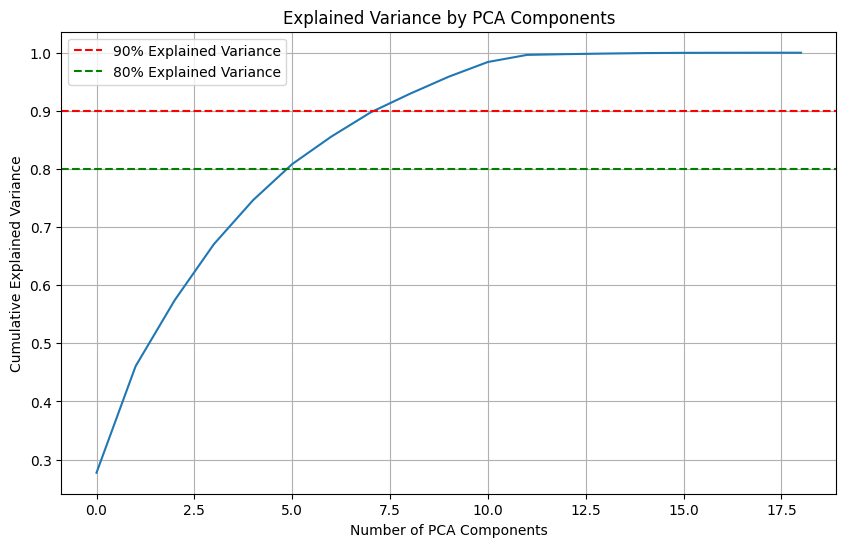

In [6]:
# Re-filtering the dataset for 'Acinetobacter spp.' in case it was modified.
bacteria_data = merged_data_clean[merged_data_clean['Bacteria'] == 'Acinetobacter spp.']
numeric_columns = bacteria_data.select_dtypes(include=[np.number]).columns
bacteria_data_scaled = scaler.fit_transform(bacteria_data[numeric_columns])

# Apply PCA without specifying the number of components to observe the explained variance
pca_full = PCA()
pca_full.fit(bacteria_data_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()


The plot of the cumulative explained variance by PCA components suggests that around 10 components explain approximately 90% of the variance in the data, which can be considered sufficient for most analytical purposes. This is the point after which the increase in explained variance starts to diminish, indicating the "elbow" of the curve.

With this information, we can reapply PCA to the data using 10 components to achieve the desired level of explained variance, ensuring that we are capturing most of the information in the data without including too much noise.

/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


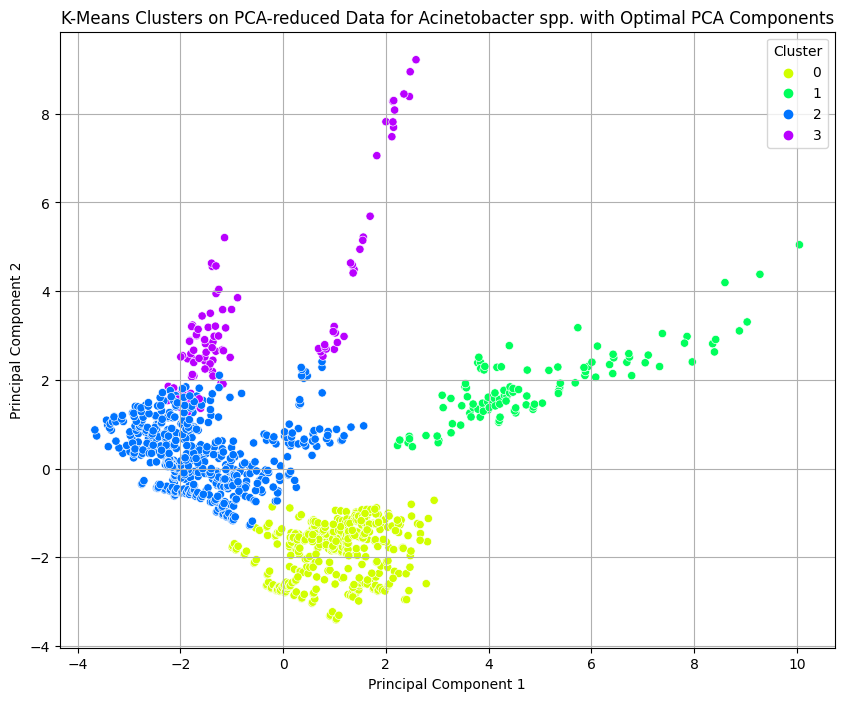

/var/folders/xm/zbjsnt8j5sn16bwvmsxbqhmr0000gn/T/ipykernel_19763/1043052481.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bacteria_data['Optimal Cluster'] = bacteria_clusters_optimal


,Unnamed: 0_x,HealthTopic,Bacteria,Drug_Class,Year,geo,RegionName,"I - 'susceptible, increased exposure' isolates _N",R - resistant isolates_N,"R - resistant isolates, percentage _%",...,Unnamed: 0,EUR_HAB,MIO_EUR,MIO_NAC,MIO_PPS,NAC_HAB,PC_CHE,PC_GDP,PPS_HAB,Optimal Cluster
0,0,Antimicrobial resistance,Acinetobacter spp.,Aminoglycosides,2012,AT,Austria,0.0,0.0,13.64955,...,1,3855.27,32499.92,32499.92,28893.44,3855.27,100.0,10.2,3427.46,0
1,328,Antimicrobial resistance,Acinetobacter spp.,Carbapenems,2012,AT,Austria,0.0,0.0,13.64955,...,1,3855.27,32499.92,32499.92,28893.44,3855.27,100.0,10.2,3427.46,0
2,656,Antimicrobial resistance,Acinetobacter spp.,"Combined resistance (fluoroquinolones, aminogl...",2012,AT,Austria,2.0,0.0,13.64955,...,1,3855.27,32499.92,32499.92,28893.44,3855.27,100.0,10.2,3427.46,0
3,1312,Antimicrobial resistance,Acinetobacter spp.,Fluoroquinolones,2012,AT,Austria,0.0,0.0,13.64955,...,1,3855.27,32499.92,32499.92,28893.44,3855.27,100.0,10.2,3427.46,0
30,1,Antimicrobial resistance,Acinetobacter spp.,Aminoglycosides,2012,BE,Belgium,0.0,0.0,13.64955,...,22,3651.44,40556.25,40556.25,35195.61,3651.44,100.0,10.5,3168.80,0


In [7]:
# Apply PCA with the optimal number of components determined from the explained variance plot
optimal_pca_components = 10
pca_optimal = PCA(n_components=optimal_pca_components)
bacteria_data_pca_optimal = pca_optimal.fit_transform(bacteria_data_scaled)

# Now we reapply K-means clustering with the optimal number of clusters determined by the silhouette scores which was 4
optimal_kmeans_clusters = 4
kmeans_optimal = KMeans(n_clusters=optimal_kmeans_clusters, random_state=42)
bacteria_clusters_optimal = kmeans_optimal.fit_predict(bacteria_data_pca_optimal)

# Visualizing the clusters with the optimal PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=bacteria_data_pca_optimal[:, 0],  # first principal component
    y=bacteria_data_pca_optimal[:, 1],  # second principal component
    hue=bacteria_clusters_optimal,
    palette=sns.color_palette("hsv", optimal_kmeans_clusters)
)
plt.title('K-Means Clusters on PCA-reduced Data for Acinetobacter spp. with Optimal PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# The clusters from this plot can now be analyzed to understand the different AMR profiles within 'Acinetobacter spp.'
# We can add these optimal cluster labels back to the original dataframe for further analysis.
bacteria_data['Optimal Cluster'] = bacteria_clusters_optimal

# Show the first few rows of the data with the new cluster assignments
bacteria_data.head()


The clustering visualization with the optimal PCA components (10 components chosen for 90% variance explanation) and the optimal number of clusters (4 clusters determined from the silhouette scores) has been created for 'Acinetobacter spp.'. The clusters are well-defined, and we can see distinct groupings in the PCA-reduced feature space.

The cluster assignments have also been added to the original data. For further analysis, you can examine the characteristics of each cluster, such as the central tendency measures (mean, median) of important features, the distribution of countries in each cluster, and how these clusters might relate to AMR profiles.

/var/folders/xm/zbjsnt8j5sn16bwvmsxbqhmr0000gn/T/ipykernel_19763/1659158287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bacteria_data['Year'] = bacteria_data['Year'].astype(str)


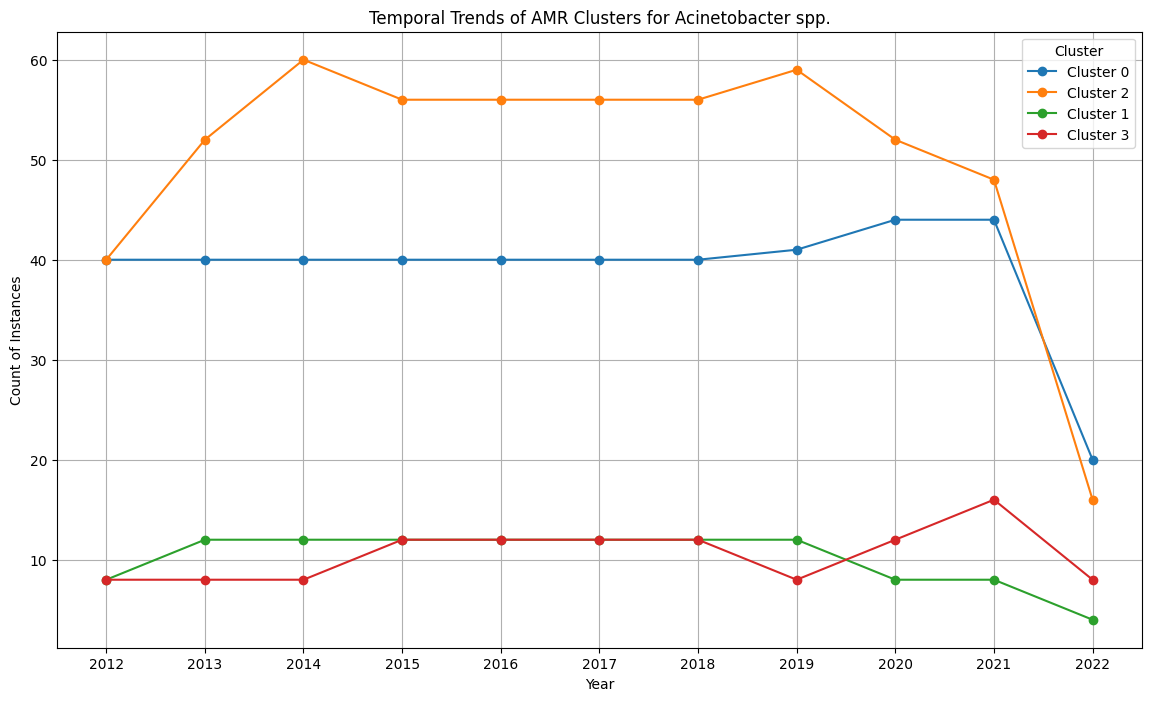

In [8]:
bacteria_data['Year'] = bacteria_data['Year'].astype(str)

# Create a line plot for each cluster
plt.figure(figsize=(14, 8))

# Plotting each cluster's trend over time
for cluster in bacteria_data['Optimal Cluster'].unique():
    # Filter the data for the current cluster
    cluster_data = bacteria_data[bacteria_data['Optimal Cluster'] == cluster]
    # Get the yearly count for the current cluster
    yearly_counts = cluster_data['Year'].value_counts().sort_index()
    # Plot
    plt.plot(yearly_counts.index, yearly_counts.values, marker='o', label=f'Cluster {cluster}')

plt.title('Temporal Trends of AMR Clusters for Acinetobacter spp.')
plt.xlabel('Year')
plt.ylabel('Count of Instances')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

/var/folders/xm/zbjsnt8j5sn16bwvmsxbqhmr0000gn/T/ipykernel_19763/2651030366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bacteria_data['num_observations'] = bacteria_data['geo'].map(observations_per_country)


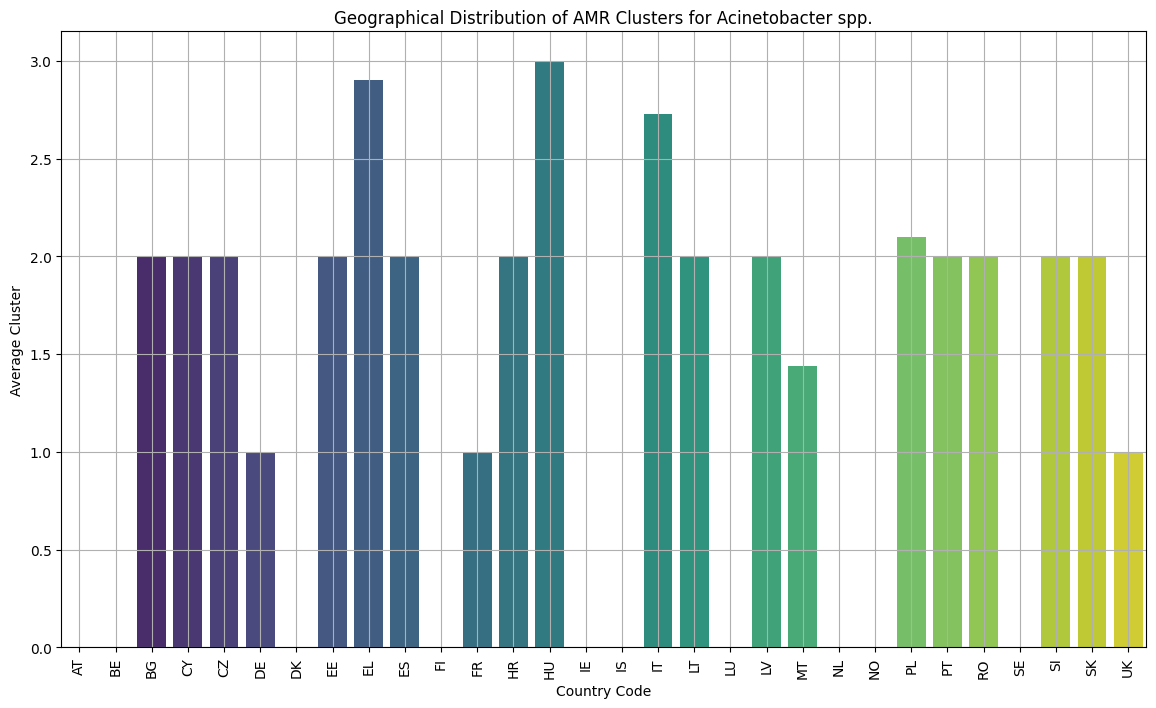

In [9]:
# Calculate the number of observations per country
observations_per_country = bacteria_data['geo'].value_counts()

# Map the observations count back onto the bacteria_data dataframe
bacteria_data['num_observations'] = bacteria_data['geo'].map(observations_per_country)

# Now, instead of directly calculating the mean cluster value for each country,
# calculate the weighted average where weights are the number of observations per country.
geo_cluster_pivot = bacteria_data.pivot_table(
    values='Optimal Cluster',
    index='geo',
    aggfunc=lambda x: np.average(x, weights=bacteria_data.loc[x.index, 'num_observations'])
).reset_index()

# The rest of your visualization code remains the same
plt.figure(figsize=(14, 8))
sns.barplot(data=geo_cluster_pivot, x='geo', y='Optimal Cluster', palette='viridis')
plt.title('Geographical Distribution of AMR Clusters for Acinetobacter spp.')
plt.xlabel('Country Code')
plt.ylabel('Average Cluster')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [10]:

# Now let's look into the correlations with socioeconomic data by computing the correlation matrix for the clusters and socioeconomic variables.
socioeconomic_variables = ['CP_EUR_HAB', 'CP_MEUR', 'EUR_HAB', 'MIO_EUR', 'MIO_NAC', 'MIO_PPS', 'NAC_HAB', 'PC_CHE', 'PC_GDP', 'PPS_HAB']
correlation_matrix = bacteria_data[['Optimal Cluster'] + socioeconomic_variables].corr()

# Show the correlation matrix
correlation_matrix[['Optimal Cluster']].sort_values(by='Optimal Cluster', ascending=False)

,Optimal Cluster
Optimal Cluster,1.000000
MIO_NAC,0.223673
MIO_PPS,-0.032262
CP_MEUR,-0.060216
MIO_EUR,-0.091118
NAC_HAB,-0.114262
PC_GDP,-0.450682
CP_EUR_HAB,-0.772441
PPS_HAB,-0.795659
EUR_HAB,-0.852939


The bar chart shows the average cluster for 'Acinetobacter spp.' by country, which gives an initial visual sense of the geographical distribution of AMR clusters. However, for a detailed geographical analysis, plotting the data on a map would be ideal as it would provide a clearer spatial context.

Regarding the correlations with socioeconomic data, the correlation matrix indicates the following:

The strongest negative correlations are with EUR_HAB, PPS_HAB, and CP_EUR_HAB. These variables are likely related to the economic status of a country or region, suggesting that lower economic indicators might correlate with higher clusters of AMR.
PC_GDP also has a significant negative correlation, which could indicate that countries with a smaller percentage of healthcare expenditure as part of GDP might see different AMR profiles.
There is a positive correlation with MIO_NAC, though the interpretation of this would require further context.
These correlations might suggest that economic factors could play a role in the distribution of AMR profiles, which aligns with the broader understanding that economic conditions can affect health outcomes and the spread of antimicrobial resistance.

The lack of correlation with PC_CHE is likely because the data is not varied (it's the same value for all observations).

In [11]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# We will perform a regression analysis with 'Optimal Cluster' as the dependent variable
# and the socioeconomic variables as the independent variables.

# Preparing the independent variables (socioeconomic factors) and the dependent variable (cluster)
X = bacteria_data[socioeconomic_variables]  # Independent variables
y = bacteria_data['Optimal Cluster']        # Dependent variable

# Add a constant to the independent variables matrix for the intercept
X_with_constant = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X_with_constant)

# Fit the model
results = model.fit()

# Get the summary of the regression
regression_summary = results.summary()

# Display the summary of the regression analysis
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Optimal Cluster   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     591.3
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        02:39:47   Log-Likelihood:                -753.54
No. Observations:                1208   AIC:                             1527.
Df Residuals:                    1198   BIC:                             1578.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CP_EUR_HAB  1.695e-05    2.8e-06      6.043      0.000    1.14e-05    2.24e-05
CP_MEUR      7.23e-07   1.35e-07      5.367      0.000    4.59e-07    9.87e-07
EUR_HAB       -0.0004   4.59e-05     -9.514      0.000      -0.001      -0.000
MIO_EUR    -1.594e-05   2.01e-06     -7.920      0.000   -1.99e-05    -1.2e-05
MIO_NAC     4.128e-07    2.8e-08     14.745      0.000    3.58e-07    4.68e-07
MIO_PPS     1.303e-05   1.95e-06      6.673      0.000     9.2e-06    1.69e-05
NAC_HAB    -8.176e-07   1.37e-07     -5.961      0.000   -1.09e-06   -5.48e-07
PC_CHE         0.0188      0.001     13.786      0.000       0.016       0.021
PC_GDP         0.1441      0.022      6.660      0.000       0.102       0.187
PPS_HAB       -0.0005   7.01e-05     -7.491      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       49.373   Durbin-Watson:                   0.458
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.717
Skew:                           0.517   Prob(JB):                     1.31e-12
Kurtosis:                       2.868   Cond. No.                     1.63e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression analysis provides an R-squared value of approximately 0.816, indicating that around 81.6% of the variability in the cluster assignment can be explained by the socioeconomic variables included in the model. Here are some key takeaways:

Significant Variables: Most socioeconomic factors appear to be significant predictors of the cluster assignment (P-value < 0.05), suggesting a strong association between these factors and the distribution of AMR profiles.
Coefficients: The coefficients indicate the direction and magnitude of the relationship between each independent variable and the dependent variable. For instance, MIO_NAC (Gross National Income in millions) has a positive coefficient, meaning that higher GNI is associated with an increase in the cluster number.
Multicollinearity: The condition number is large, which may indicate multicollinearity among the independent variables. This is when two or more variables are highly correlated and can lead to instability in the coefficient estimates.
To interpret these results in the context of AMR spread, one might infer that certain economic indicators are associated with the prevalence of more resistant or less resistant strains of 'Acinetobacter spp.' For instance, countries with higher GDP might afford better healthcare infrastructure and practices that can prevent or control the spread of resistant strains.

In [12]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming your cleaned dataset is named 'bacteria_data' and includes the 'Optimal Cluster'
# and all the socioeconomic variables as defined earlier in your notebook.
socioeconomic_variables = ['CP_EUR_HAB', 'CP_MEUR', 'EUR_HAB', 'MIO_EUR', 'MIO_NAC', 'MIO_PPS', 'NAC_HAB', 'PC_CHE', 'PC_GDP', 'PPS_HAB']

# Extract the relevant features for the VIF calculation
X = bacteria_data[socioeconomic_variables]

# Add a constant to the dataset which is required for VIF calculation
X = add_constant(X)

# Create a DataFrame that will contain the names of all the feature variables and their corresponding VIFs
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Output the VIF results
print(vif_data)


      Feature         VIF
0  CP_EUR_HAB   21.448488
1     CP_MEUR   67.918679
2     EUR_HAB   42.438333
3     MIO_EUR  191.333198
4     MIO_NAC    1.468063
5     MIO_PPS  148.726808
6     NAC_HAB    1.747226
7      PC_CHE  108.891381
8      PC_GDP    9.844993
9     PPS_HAB   33.486411


The Variance Inflation Factor (VIF) results you've shown indicate a significant level of multicollinearity in several of your model's variables. Here's how to interpret and summarize these results:

Interpretation of VIF Results:
High VIF Variables: MIO_EUR, MIO_PPS, and PC_CHE have extremely high VIF values (greater than 100), indicating very strong multicollinearity. This suggests that these variables share a substantial amount of information with other variables in the model, which can distort the reliability of your regression coefficients.
Moderately High VIF: CP_MEUR, EUR_HAB, and PPS_HAB also demonstrate high VIF values, suggesting moderate to high multicollinearity.
Acceptable VIF: CP_EUR_HAB, NAC_HAB, PC_GDP, and MIO_NAC have lower VIF values, suggesting less concern regarding multicollinearity, although CP_EUR_HAB and PC_GDP are approaching thresholds where caution might be advised.
Summary of Results:
The presence of high multicollinearity in several key variables indicates that the statistical inferences made from the regression model about these variables may not be reliable. High multicollinearity can increase the variance of the coefficient estimates and make the model more sensitive to changes in model specifications.

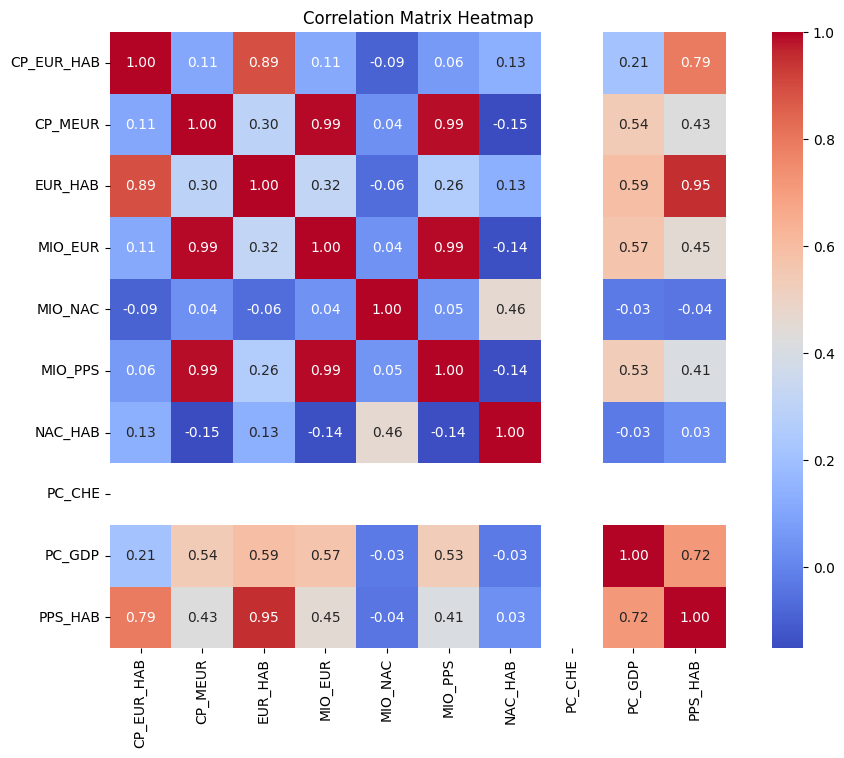

In [13]:
# Calculate the correlation matrix for the socioeconomic variables
correlation_matrix = bacteria_data[socioeconomic_variables].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [14]:
# Remove one of each highly correlated pair (threshold > 0.8)
reduced_variables = [var for var in socioeconomic_variables if var not in ['MIO_EUR', 'PPS_HAB']]  # Example of removing variables

In [15]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(bacteria_data[socioeconomic_variables])
y = bacteria_data['Optimal Cluster']

# Lasso regression with cross-validation to select the best alpha
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Displaying the coefficients
lasso_coeffs = pd.DataFrame({'Feature': socioeconomic_variables, 'Lasso Coeff': lasso.coef_})
print(lasso_coeffs)


      Feature  Lasso Coeff
0  CP_EUR_HAB     0.314277
1     CP_MEUR     0.496921
2     EUR_HAB    -0.811864
3     MIO_EUR    -1.085717
4     MIO_NAC     0.227104
5     MIO_PPS     0.804025
6     NAC_HAB    -0.095907
7      PC_CHE     0.000000
8      PC_GDP     0.227088
9     PPS_HAB    -0.506426


In [16]:
# Adjusted set of variables
adjusted_variables = ['MIO_EUR', 'EUR_HAB', 'MIO_NAC', 'MIO_PPS', 'NAC_HAB', 'PC_GDP']

# Rerun the regression or any other analysis with this reduced set of variables to confirm improvements in model performance and multicollinearity.


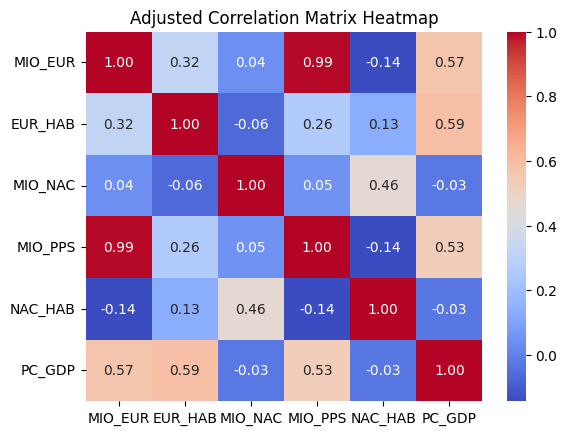

In [17]:
# Adjusted set of variables
adjusted_variables = ['MIO_EUR', 'EUR_HAB', 'MIO_NAC', 'MIO_PPS', 'NAC_HAB', 'PC_GDP']

# Compute the correlation matrix for the adjusted variables
adjusted_correlation_matrix = bacteria_data[adjusted_variables].corr()

# Plot the adjusted correlation matrix as a heatmap
sns.heatmap(adjusted_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Adjusted Correlation Matrix Heatmap')
plt.show()


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Adding a constant to the dataset (required for VIF calculation)
X_adjusted = add_constant(bacteria_data[adjusted_variables])

# Calculate VIF for the adjusted set of features
vif_data_adjusted = pd.DataFrame()
vif_data_adjusted['Feature'] = X_adjusted.columns
vif_data_adjusted['VIF'] = [variance_inflation_factor(X_adjusted.values, i) for i in range(X_adjusted.shape[1])]

print(vif_data_adjusted)


   Feature         VIF
0    const   32.844898
1  MIO_EUR  126.130927
2  EUR_HAB    2.072793
3  MIO_NAC    1.340113
4  MIO_PPS  119.433572
5  NAC_HAB    1.417943
6   PC_GDP    2.074396


In [19]:
import statsmodels.api as sm

# Prepare the independent variables (now adjusted) and the dependent variable
X_adjusted = bacteria_data[adjusted_variables]
y = bacteria_data['Optimal Cluster']  # Dependent variable remains the same

# Add a constant for the intercept in the model
X_adjusted_with_constant = sm.add_constant(X_adjusted)

# Create a new OLS regression model with the adjusted variables
model_adjusted = sm.OLS(y, X_adjusted_with_constant)

# Fit the model
results_adjusted = model_adjusted.fit()

# Display the summary of the new regression analysis
print(results_adjusted.summary())


                            OLS Regression Results                            
Dep. Variable:        Optimal Cluster   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     774.0
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        02:39:48   Log-Likelihood:                -821.06
No. Observations:                1208   AIC:                             1656.
Df Residuals:                    1201   BIC:                             1692.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6362      0.079     33.386      0.0

In [20]:
import statsmodels.api as sm
import pandas as pd

# Assuming 'bacteria_data' is your DataFrame and includes all necessary variables
# Redefining the adjusted variables, excluding 'MIO_PPS'
adjusted_variables = ['MIO_EUR', 'EUR_HAB', 'MIO_NAC', 'NAC_HAB', 'PC_GDP']

# Prepare the independent variables (now adjusted) and the dependent variable
X_adjusted = bacteria_data[adjusted_variables]
y = bacteria_data['Optimal Cluster']  # Dependent variable remains the same

# Add a constant for the intercept in the model
X_adjusted_with_constant = sm.add_constant(X_adjusted)

# Create a new OLS regression model with the adjusted variables
model_adjusted = sm.OLS(y, X_adjusted_with_constant)

# Fit the model
results_adjusted = model_adjusted.fit()

# Display the summary of the new regression analysis
print(results_adjusted.summary())


                            OLS Regression Results                            
Dep. Variable:        Optimal Cluster   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     913.2
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        02:39:48   Log-Likelihood:                -829.58
No. Observations:                1208   AIC:                             1671.
Df Residuals:                    1202   BIC:                             1702.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7316      0.076     35.938      0.0

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# Prepare the data
X_adjusted = bacteria_data[adjusted_variables]
y = bacteria_data['Optimal Cluster']

# Initialize the Linear Regression model
lin_reg = LinearRegression()

# Define the scorer for cross-validation
scorer = make_scorer(r2_score)

# Perform k-fold cross-validation
cv_scores = cross_val_score(lin_reg, X_adjusted, y, cv=5, scoring=scorer)

# Print out the mean cross-validation score
print("Mean cross-validation R^2: {:.2f}".format(cv_scores.mean()))


Mean cross-validation R^2: 0.77


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Variables previously defined (assuming 'socioeconomic_variables' were adjusted and validated for multicollinearity)
socioeconomic_variables = ['MIO_EUR', 'EUR_HAB', 'MIO_NAC', 'MIO_PPS', 'NAC_HAB', 'PC_GDP']  # Adjust if needed

# Preparing the data
X = bacteria_data[socioeconomic_variables]
y = bacteria_data['Optimal Cluster']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating and fitting the Linear Regression model to the training data
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Making predictions on the test data
predictions = model.predict(X_test_scaled)

# Evaluating the model
test_r2 = r2_score(y_test, predictions)
test_mse = mean_squared_error(y_test, predictions)

# Displaying the results
print("Test R^2 Score:", test_r2)
print("Test Mean Squared Error:", test_mse)


Test R^2 Score: 0.7931534121020566
Test Mean Squared Error: 0.23054260863094153


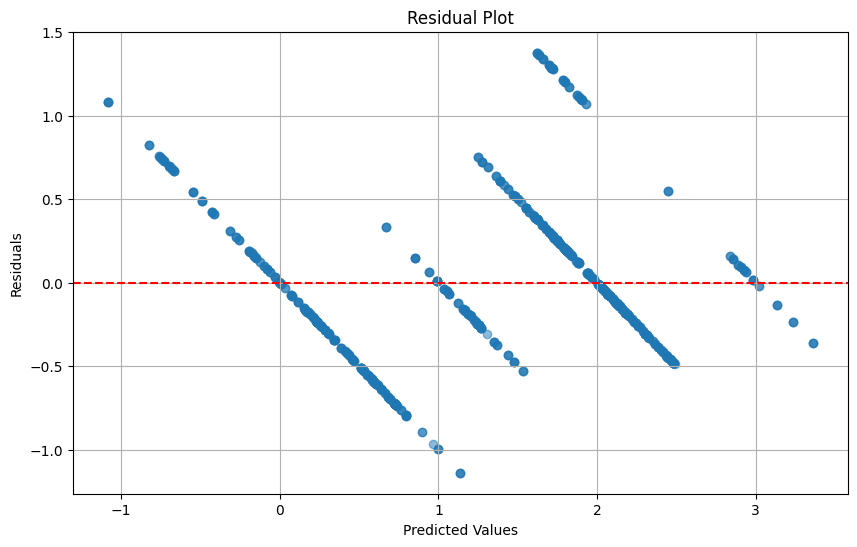

In [23]:
import matplotlib.pyplot as plt

# Predictions on the training set for residual plot
train_predictions = model.predict(X_train_scaled)

# Calculating residuals
residuals = y_train - train_predictions

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(train_predictions, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Checking for any patterns in residuals (should be randomly dispersed around the horizontal line)


         Coefficient  Absolute Coefficient
EUR_HAB    -0.877516              0.877516
MIO_PPS     0.739853              0.739853
MIO_EUR    -0.549580              0.549580
MIO_NAC     0.186182              0.186182
NAC_HAB    -0.047801              0.047801
PC_GDP     -0.034347              0.034347


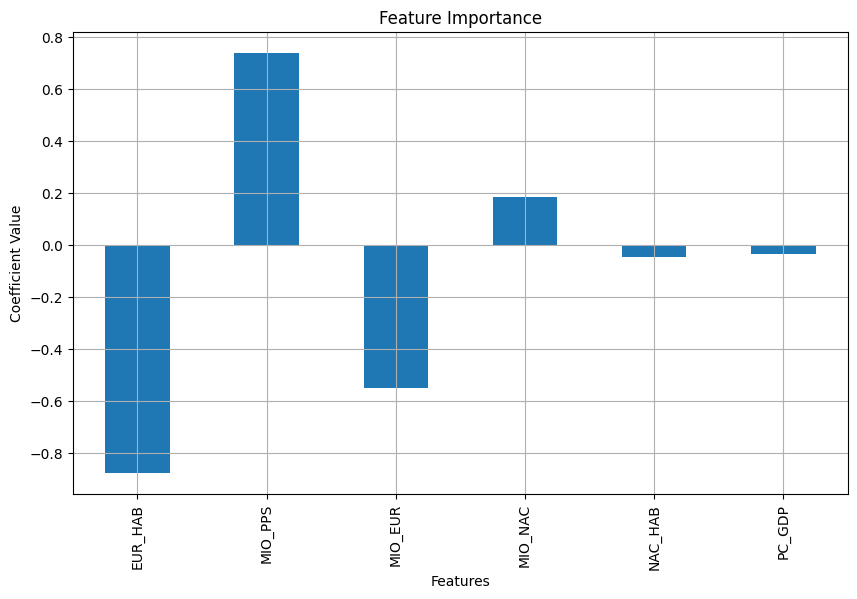

In [24]:
import pandas as pd

# Retrieve the coefficients from the linear model and match them with the column names
feature_importance = pd.DataFrame(model.coef_, index=socioeconomic_variables, columns=['Coefficient'])

# Display the coefficients sorted by their absolute values
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance_sorted = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
print(feature_importance_sorted)

# Plotting feature importance for visual comparison
plt.figure(figsize=(10, 6))
feature_importance_sorted['Coefficient'].plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.show()


Random Forest Test R^2 Score: 0.9740719317328758
Random Forest Test Mean Squared Error: 0.028898347107438018
         Importance
EUR_HAB    0.859665
MIO_PPS    0.056666
MIO_EUR    0.045760
MIO_NAC    0.025060
NAC_HAB    0.010648
PC_GDP     0.002201


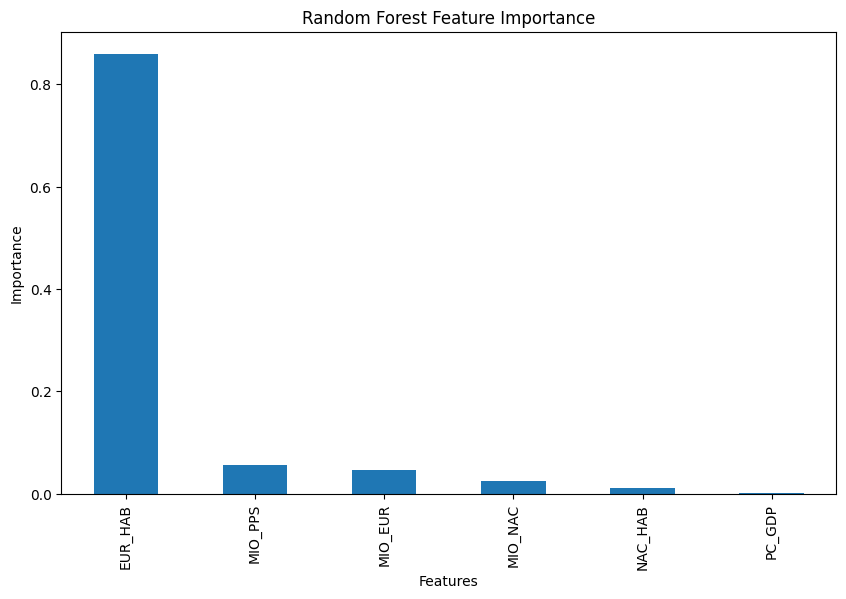

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model on the training data
rf_model.fit(X_train_scaled, y_train)

# Making predictions on the test data
rf_predictions = rf_model.predict(X_test_scaled)

# Evaluating the model
rf_test_r2 = r2_score(y_test, rf_predictions)
rf_test_mse = mean_squared_error(y_test, rf_predictions)

print("Random Forest Test R^2 Score:", rf_test_r2)
print("Random Forest Test Mean Squared Error:", rf_test_mse)

# Feature Importance
rf_feature_importance = pd.DataFrame(rf_model.feature_importances_, index=socioeconomic_variables, columns=['Importance'])
rf_feature_importance_sorted = rf_feature_importance.sort_values(by='Importance', ascending=False)
print(rf_feature_importance_sorted)

# Plotting feature importance for visual comparison
plt.figure(figsize=(10, 6))
rf_feature_importance_sorted['Importance'].plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Standardizing the entire feature set before cross-validation
X_scaled = scaler.fit_transform(bacteria_data[socioeconomic_variables])

# Performing 10-fold cross-validation
cv_scores = cross_val_score(rf, X_scaled, bacteria_data['Optimal Cluster'], cv=10, scoring='r2')

# Printing the results
print("CV R^2 Scores:", cv_scores)
print("Average CV R^2 Score:", cv_scores.mean())
print("Standard Deviation of CV R^2 Scores:", cv_scores.std())


CV R^2 Scores: [0.81040723 0.99780308 0.99953573 0.9594668  1.         0.99999695
 0.9671285  0.93968123 0.89897316 0.77850015]
Average CV R^2 Score: 0.935149282123582
Standard Deviation of CV R^2 Scores: 0.07715227889276823


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have a 'year' column to segregate data
# Separating the latest year as a hold-out set
train_data = bacteria_data[bacteria_data['Year'] < '2021']
test_data = bacteria_data[bacteria_data['Year'] == '2021']

# Prepare the feature vectors and targets
X_train = train_data[socioeconomic_variables]
y_train = train_data['Optimal Cluster']
X_test = test_data[socioeconomic_variables]
y_test = test_data['Optimal Cluster']

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the hold-out test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'Out-of-Time Validation R² Score: {r2}')
print(f'Out-of-Time Validation MSE: {mse}')


Out-of-Time Validation R² Score: 0.7754443043263941
Out-of-Time Validation MSE: 0.2803608566674034


In [28]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initializing the Gradient Boosting Regressor
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fitting the GBM model on the scaled training data
gbm.fit(X_train_scaled, y_train)

# Making predictions on the test data
gbm_predictions = gbm.predict(X_test_scaled)

# Calculating the R^2 score and MSE for the GBM model
gbm_r2 = r2_score(y_test, gbm_predictions)
gbm_mse = mean_squared_error(y_test, gbm_predictions)

print("Gradient Boosting Machine Test R^2 Score:", gbm_r2)
print("Gradient Boosting Machine Test MSE:", gbm_mse)


Gradient Boosting Machine Test R^2 Score: 0.7784437516344889
Gradient Boosting Machine Test MSE: 0.27661600568821254


In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Decision Tree model
dt = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
dt.fit(X_train_scaled, y_train)

# Make predictions on the test data
dt_predictions = dt.predict(X_test_scaled)

# Calculating the R^2 score and MSE for the Decision Tree model
dt_r2 = r2_score(y_test, dt_predictions)
dt_mse = mean_squared_error(y_test, dt_predictions)

print("Decision Tree Test R^2 Score:", dt_r2)
print("Decision Tree Test MSE:", dt_mse)


Decision Tree Test R^2 Score: 0.7997619047619048
Decision Tree Test MSE: 0.25


In [30]:
from xgboost import XGBRegressor

# Initialize the XGBoost model
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model on the scaled training data
xgb.fit(X_train_scaled, y_train)

# Make predictions on the test data
xgb_predictions = xgb.predict(X_test_scaled)

# Calculating the R^2 score and MSE for the XGBoost model
xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

print("XGBoost Test R^2 Score:", xgb_r2)
print("XGBoost Test MSE:", xgb_mse)


XGBoost Test R^2 Score: 0.7868497043938616
XGBoost Test MSE: 0.26612105872347847


In [31]:
# Assuming 'results' now stores both MSE and R² for each model
results = {
    'Linear Regression': {'MSE': test_mse, 'R²': test_r2},
    'Random Forest': {'MSE': rf_test_mse, 'R²': rf_test_r2},
    'Gradient Boosting Machine': {'MSE': gbm_mse, 'R²': gbm_r2},
    'Decision Tree': {'MSE': dt_mse, 'R²': dt_r2},
    'XGBoost': {'MSE': xgb_mse, 'R²': xgb_r2}
}

# Creating a DataFrame from the results dictionary
results_df = pd.DataFrame(results).T  # Transpose to switch rows and columns
results_df.columns = ['MSE', 'R²']  # Naming the columns

print(results_df)


                                MSE        R²
Linear Regression          0.230543  0.793153
Random Forest              0.028898  0.974072
Gradient Boosting Machine  0.276616  0.778444
Decision Tree              0.250000  0.799762
XGBoost                    0.266121  0.786850


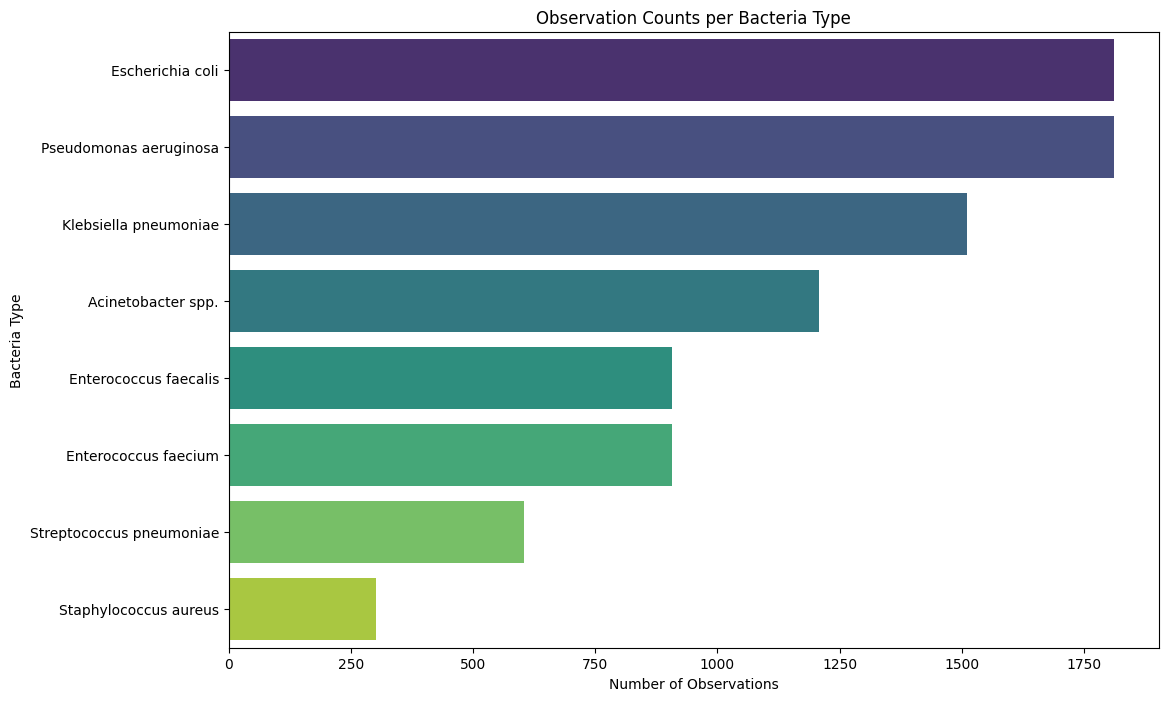

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each bacteria type in the dataset
bacteria_counts = merged_data['Bacteria'].value_counts()

# Plotting the bacteria observation counts
plt.figure(figsize=(12, 8))
sns.barplot(x=bacteria_counts.values, y=bacteria_counts.index, palette="viridis")
plt.title('Observation Counts per Bacteria Type')
plt.xlabel('Number of Observations')
plt.ylabel('Bacteria Type')
plt.show()


In [33]:
# Define the threshold for minimum observations
threshold = 100

# Filter the dataset to include only bacteria with observations greater than the threshold
filtered_data = merged_data[merged_data['Bacteria'].map(bacteria_counts) > threshold]

# Check the filtered dataset
print(filtered_data['Bacteria'].value_counts())
filtered_data.info()


Bacteria
Escherichia coli            1812
Pseudomonas aeruginosa      1812
Klebsiella pneumoniae       1510
Acinetobacter spp.          1208
Enterococcus faecalis        906
Enterococcus faecium         906
Streptococcus pneumoniae     604
Staphylococcus aureus        302
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9060 entries, 0 to 9059
Data columns (total 27 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0_x                                       9060 non-null   int64  
 1   HealthTopic                                        9060 non-null   object 
 2   Bacteria                                           9060 non-null   object 
 3   Drug_Class                                         9060 non-null   object 
 4   Year                                               9060 non-null   int64  
 5   geo                          

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_data_clean is already loaded and available

# List of bacteria to iterate through
bacteria_list = merged_data_clean['Bacteria'].unique()

# Define a DataFrame to store all results
results_df = pd.DataFrame()

for bacteria in bacteria_list:
    print(f"Processing {bacteria}...")
    data = merged_data_clean[merged_data_clean['Bacteria'] == bacteria]
    scaler = StandardScaler()
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data_scaled = scaler.fit_transform(data[numeric_columns])

    # Determine the optimal number of PCA components
    pca = PCA()
    data_pca = pca.fit_transform(data_scaled)
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    n_pca_components = np.where(cum_var >= 0.90)[0][0] + 1  # 90% variance threshold
    pca = PCA(n_components=n_pca_components)
    data_pca = pca.fit_transform(data_scaled)

    # Determine the optimal number of clusters
    range_clusters = range(2, 11)
    silhouette_scores = []
    for n_clusters in range_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data_pca)
        silhouette_scores.append(silhouette_score(data_pca, cluster_labels))
    optimal_clusters = range_clusters[np.argmax(silhouette_scores)]
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_pca)
    data['Cluster'] = clusters

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[numeric_columns], data['Cluster'], test_size=0.2, random_state=42)

    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
        'Random Forest': RandomForestRegressor(random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        r2 = r2_score(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)

        # Append results using concat for new pandas versions
        new_row = pd.DataFrame({
            'Bacteria': [bacteria],
            'Model': [name],
            'Optimal PCA Components': [n_pca_components],
            'Optimal Clusters': [optimal_clusters],
            'R²': [r2],
            'MSE': [mse],
            'MAE': [mae]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.to_csv('model_comparison_results.csv', index=False)
print(results_df)


Processing Acinetobacter spp....


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Enterococcus faecalis...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Enterococcus faecium...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Escherichia coli...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Klebsiella pneumoniae...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Pseudomonas aeruginosa...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Staphylococcus aureus...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Streptococcus pneumoniae...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

                    Bacteria              Model  Optimal PCA Components   
0         Acinetobacter spp.  Linear Regression                       9  \
1         Acinetobacter spp.   Lasso Regression                       9   
2         Acinetobacter spp.      Random Forest                       9   
3      Enterococcus faecalis  Linear Regression                       9   
4      Enterococcus faecalis   Lasso Regression                       9   
5      Enterococcus faecalis      Random Forest                       9   
6       Enterococcus faecium  Linear Regression                       8   
7       Enterococcus faecium   Lasso Regression                       8   
8       Enterococcus faecium      Random Forest                       8   
9           Escherichia coli  Linear Regression                       9   
10          Escherichia coli   Lasso Regression                       9   
11          Escherichia coli      Random Forest                       9   
12     Klebsiella pneumon

In [35]:
results_df

,Bacteria,Model,Optimal PCA Components,Optimal Clusters,R²,MSE,MAE
0,Acinetobacter spp.,Linear Regression,9,5,0.758059,0.387128,0.407551
1,Acinetobacter spp.,Lasso Regression,9,5,0.726079,0.438300,0.458523
2,Acinetobacter spp.,Random Forest,9,5,0.966144,0.054174,0.018099
3,Enterococcus faecalis,Linear Regression,9,2,0.887353,0.008519,0.054236
4,Enterococcus faecalis,Lasso Regression,9,2,0.874173,0.009516,0.054163
5,Enterococcus faecalis,Random Forest,9,2,0.999811,0.000014,0.000330
6,Enterococcus faecium,Linear Regression,8,8,0.570330,3.016404,1.500380
7,Enterococcus faecium,Lasso Regression,8,8,0.537585,3.246284,1.555500
8,Enterococcus faecium,Random Forest,8,8,0.951796,0.338403,0.149286
9,Escherichia coli,Linear Regression,9,2,0.829847,0.018478,0.072579


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

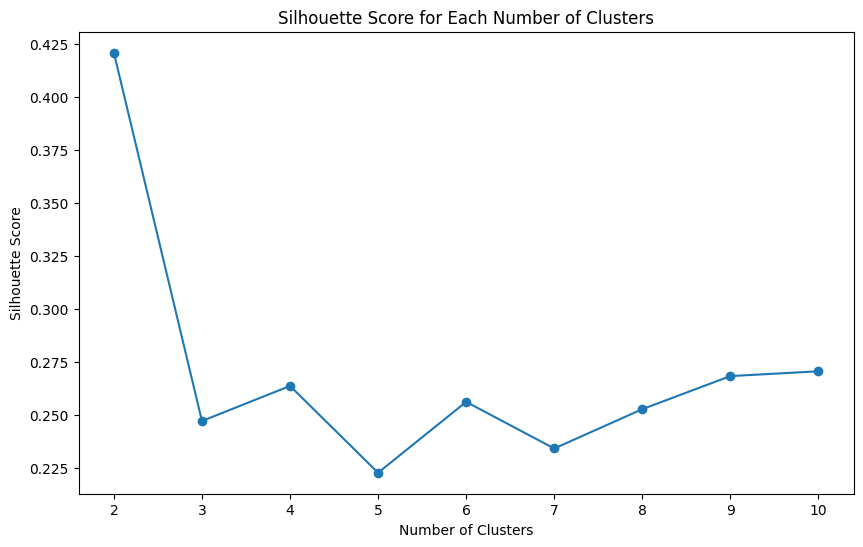

/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/xm/zbjsnt8j5sn16bwvmsxbqhmr0000gn/T/ipykernel_19763/3067525273.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bacteria_data['Cluster'] = bacteria_clusters


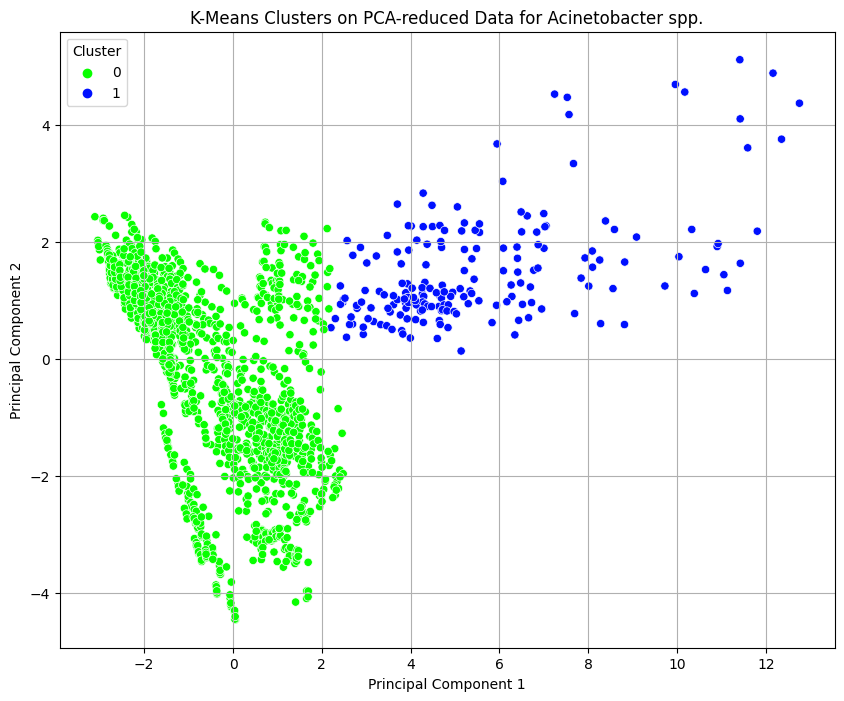

(2,
     Unnamed: 0_x               HealthTopic          Bacteria   
 10          7243  Antimicrobial resistance  Escherichia coli  \
 11          7903  Antimicrobial resistance  Escherichia coli   
 12          8561  Antimicrobial resistance  Escherichia coli   
 13          9221  Antimicrobial resistance  Escherichia coli   
 14         10541  Antimicrobial resistance  Escherichia coli   
 
                                            Drug_Class  Year geo RegionName   
 10                                    Aminoglycosides  2012  AT    Austria  \
 11                                   Aminopenicillins  2012  AT    Austria   
 12                                        Carbapenems  2012  AT    Austria   
 13  Combined resistance (third-generation cephalos...  2012  AT    Austria   
 14                                   Fluoroquinolones  2012  AT    Austria   
 
     I - 'susceptible, increased exposure' isolates _N   
 10                                               41.0  \
 11         

In [36]:
# Filter the dataset for the first bacteria type: 'Acinetobacter spp.'
bacteria_data = merged_data_clean[merged_data_clean['Bacteria'] == 'Escherichia coli']

# Standardize the numerical data
scaler = StandardScaler()
numeric_columns = bacteria_data.select_dtypes(include=[np.number]).columns
bacteria_data_scaled = scaler.fit_transform(bacteria_data[numeric_columns])

# Apply PCA
pca = PCA(n_components=0.9)  # We retain 90% of variance as per the initial approach
bacteria_data_pca = pca.fit_transform(bacteria_data_scaled)

# Find the optimal number of clusters using silhouette score
range_n_clusters = list(range(2, 11))
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(bacteria_data_pca)
    silhouette_avg.append(silhouette_score(bacteria_data_pca, cluster_labels))

# Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Each Number of Clusters')
plt.show()

# Perform K-means clustering with the optimal number of clusters
optimal_clusters = np.argmax(silhouette_avg) + 2  # plus 2 because range starts at 2
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
bacteria_clusters = kmeans_optimal.fit_predict(bacteria_data_pca)

# Add the cluster labels to the bacteria data subset
bacteria_data['Cluster'] = bacteria_clusters

# Visualizing the clusters in the PCA reduced data
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=bacteria_data_pca[:, 0],
    y=bacteria_data_pca[:, 1],
    hue=bacteria_clusters,
    palette=sns.color_palette("hsv", optimal_clusters)
)
plt.title('K-Means Clusters on PCA-reduced Data for Acinetobacter spp.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Output the optimal number of clusters found
optimal_clusters, bacteria_data.head()

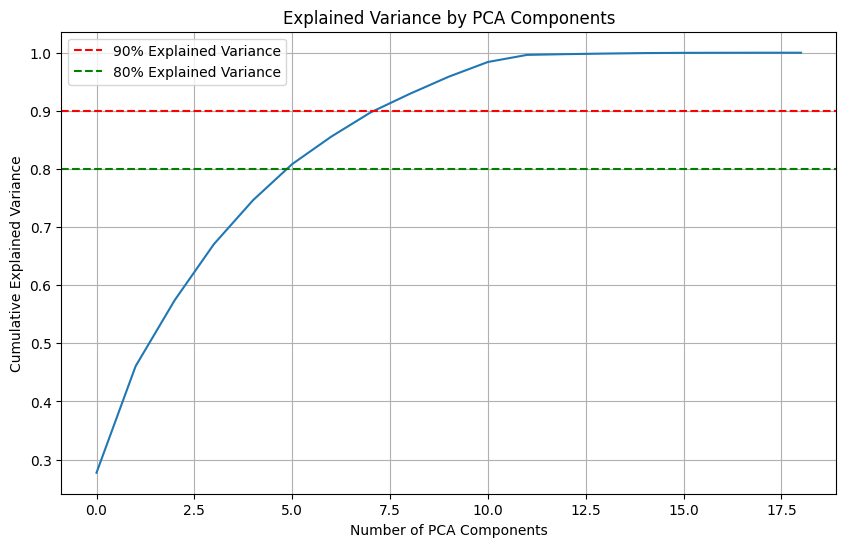

In [37]:
# Re-filtering the dataset for 'Acinetobacter spp.' in case it was modified.
bacteria_data = merged_data_clean[merged_data_clean['Bacteria'] == 'Acinetobacter spp.']
numeric_columns = bacteria_data.select_dtypes(include=[np.number]).columns
bacteria_data_scaled = scaler.fit_transform(bacteria_data[numeric_columns])

# Apply PCA without specifying the number of components to observe the explained variance
pca_full = PCA()
pca_full.fit(bacteria_data_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [38]:
# Find the highest silhouette score and the corresponding number of clusters
highest_silhouette_score = max(silhouette_avg)
optimal_number_of_clusters = range_n_clusters[np.argmax(silhouette_avg)]

print("Highest Silhouette Score:", highest_silhouette_score)
print("Optimal Number of Clusters:", optimal_number_of_clusters)


Highest Silhouette Score: 0.4209317105337493
Optimal Number of Clusters: 2


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


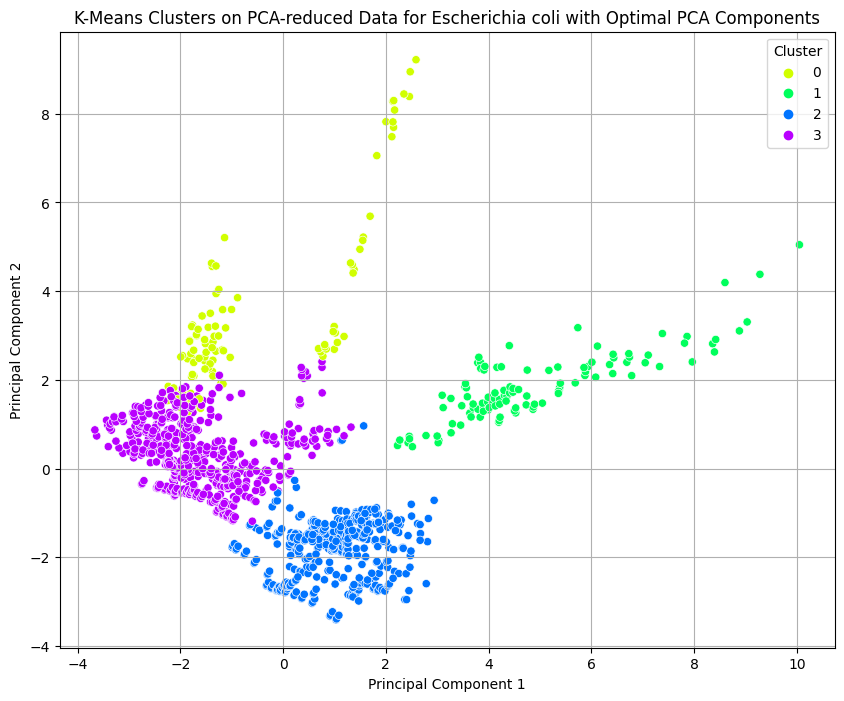

/var/folders/xm/zbjsnt8j5sn16bwvmsxbqhmr0000gn/T/ipykernel_19763/3534123342.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bacteria_data['Optimal Cluster'] = bacteria_clusters_optimal


,Unnamed: 0_x,HealthTopic,Bacteria,Drug_Class,Year,geo,RegionName,"I - 'susceptible, increased exposure' isolates _N",R - resistant isolates_N,"R - resistant isolates, percentage _%",...,Unnamed: 0,EUR_HAB,MIO_EUR,MIO_NAC,MIO_PPS,NAC_HAB,PC_CHE,PC_GDP,PPS_HAB,Optimal Cluster
0,0,Antimicrobial resistance,Acinetobacter spp.,Aminoglycosides,2012,AT,Austria,0.0,0.0,13.64955,...,1,3855.27,32499.92,32499.92,28893.44,3855.27,100.0,10.2,3427.46,2
1,328,Antimicrobial resistance,Acinetobacter spp.,Carbapenems,2012,AT,Austria,0.0,0.0,13.64955,...,1,3855.27,32499.92,32499.92,28893.44,3855.27,100.0,10.2,3427.46,2
2,656,Antimicrobial resistance,Acinetobacter spp.,"Combined resistance (fluoroquinolones, aminogl...",2012,AT,Austria,2.0,0.0,13.64955,...,1,3855.27,32499.92,32499.92,28893.44,3855.27,100.0,10.2,3427.46,2
3,1312,Antimicrobial resistance,Acinetobacter spp.,Fluoroquinolones,2012,AT,Austria,0.0,0.0,13.64955,...,1,3855.27,32499.92,32499.92,28893.44,3855.27,100.0,10.2,3427.46,2
30,1,Antimicrobial resistance,Acinetobacter spp.,Aminoglycosides,2012,BE,Belgium,0.0,0.0,13.64955,...,22,3651.44,40556.25,40556.25,35195.61,3651.44,100.0,10.5,3168.80,2


In [39]:
# Apply PCA with the optimal number of components determined from the explained variance plot
optimal_pca_components = 7
pca_optimal = PCA(n_components=optimal_pca_components)
bacteria_data_pca_optimal = pca_optimal.fit_transform(bacteria_data_scaled)

# Now we reapply K-means clustering with the optimal number of clusters determined by the silhouette scores which was 4
optimal_kmeans_clusters = 4
kmeans_optimal = KMeans(n_clusters=optimal_kmeans_clusters, random_state=42)
bacteria_clusters_optimal = kmeans_optimal.fit_predict(bacteria_data_pca_optimal)

# Visualizing the clusters with the optimal PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=bacteria_data_pca_optimal[:, 0],  # first principal component
    y=bacteria_data_pca_optimal[:, 1],  # second principal component
    hue=bacteria_clusters_optimal,
    palette=sns.color_palette("hsv", optimal_kmeans_clusters)
)
plt.title('K-Means Clusters on PCA-reduced Data for Escherichia coli with Optimal PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# The clusters from this plot can now be analyzed to understand the different AMR profiles within 'Acinetobacter spp.'
# We can add these optimal cluster labels back to the original dataframe for further analysis.
bacteria_data['Optimal Cluster'] = bacteria_clusters_optimal

# Show the first few rows of the data with the new cluster assignments
bacteria_data.head()


In [40]:
# Now let's look into the correlations with socioeconomic data by computing the correlation matrix for the clusters and socioeconomic variables.
socioeconomic_variables = ['CP_EUR_HAB', 'CP_MEUR', 'EUR_HAB', 'MIO_EUR', 'MIO_NAC', 'MIO_PPS', 'NAC_HAB', 'PC_CHE', 'PC_GDP', 'PPS_HAB']
correlation_matrix = bacteria_data[['Optimal Cluster'] + socioeconomic_variables].corr()

# Show the correlation matrix
correlation_matrix[['Optimal Cluster']].sort_values(by='Optimal Cluster', ascending=False)

,Optimal Cluster
Optimal Cluster,1.000000
NAC_HAB,-0.227398
CP_EUR_HAB,-0.233426
EUR_HAB,-0.319916
PPS_HAB,-0.345470
PC_GDP,-0.345969
MIO_PPS,-0.441207
MIO_EUR,-0.457698
CP_MEUR,-0.470342
MIO_NAC,-0.487647


In [41]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# We will perform a regression analysis with 'Optimal Cluster' as the dependent variable
# and the socioeconomic variables as the independent variables.

# Preparing the independent variables (socioeconomic factors) and the dependent variable (cluster)
X = bacteria_data[socioeconomic_variables]  # Independent variables
y = bacteria_data['Optimal Cluster']        # Dependent variable

# Add a constant to the independent variables matrix for the intercept
X_with_constant = sm.add_constant(X)

# Create a linear regression model
model = sm.OLS(y, X_with_constant)

# Fit the model
results = model.fit()

# Get the summary of the regression
regression_summary = results.summary()

# Display the summary of the regression analysis
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Optimal Cluster   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     161.5
Date:                Wed, 01 May 2024   Prob (F-statistic):          1.18e-199
Time:                        02:40:04   Log-Likelihood:                -1169.3
No. Observations:                1208   AIC:                             2359.
Df Residuals:                    1198   BIC:                             2410.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CP_EUR_HAB -3.478e-05   3.96e-06     -8.792      0.000   -4.25e-05    -2.7e-05
CP_MEUR    -1.274e-06    1.9e-07     -6.705      0.000   -1.65e-06   -9.01e-07
EUR_HAB        0.0001   6.48e-05      1.695      0.090   -1.73e-05       0.000
MIO_EUR     5.587e-06   2.84e-06      1.968      0.049     1.7e-08    1.12e-05
MIO_NAC    -8.745e-07   3.95e-08    -22.140      0.000   -9.52e-07   -7.97e-07
MIO_PPS     1.924e-06   2.75e-06      0.699      0.485   -3.48e-06    7.33e-06
NAC_HAB    -8.663e-08   1.94e-07     -0.448      0.654   -4.66e-07    2.93e-07
PC_CHE         0.0450      0.002     23.426      0.000       0.041       0.049
PC_GDP        -0.2858      0.031     -9.362      0.000      -0.346      -0.226
PPS_HAB        0.0005   9.89e-05      5.451      0.000       0.000       0.001
==============================================================================
Omnibus:                      434.302   Durbin-Watson:                   0.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2052.386
Skew:                          -1.626   Prob(JB):                         0.00
Kurtosis:                       8.495   Cond. No.                     1.63e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

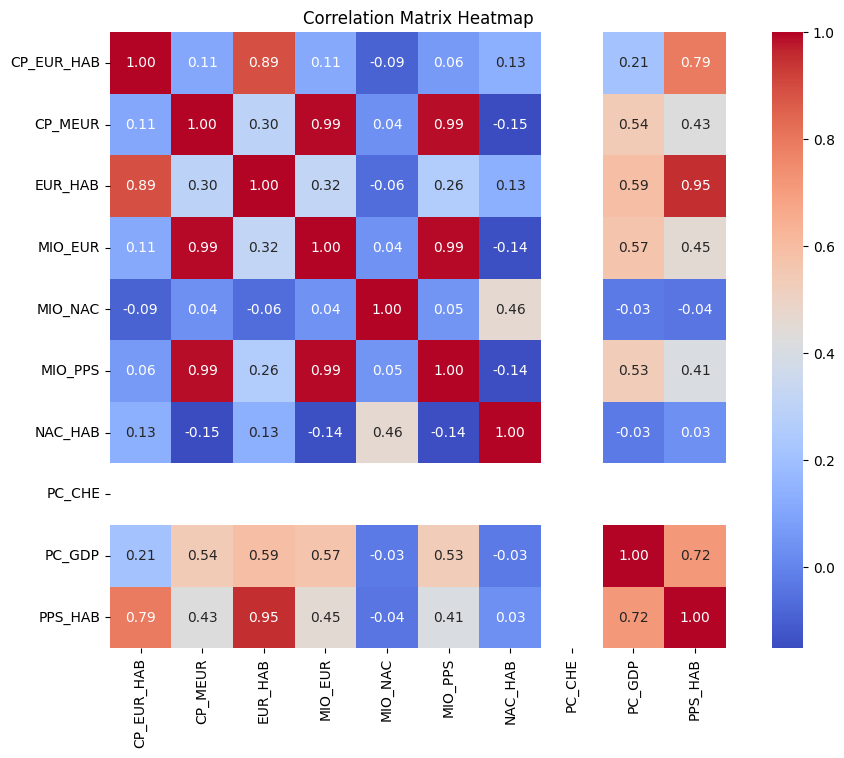

In [42]:
# Calculate the correlation matrix for the socioeconomic variables
correlation_matrix = bacteria_data[socioeconomic_variables].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [43]:
# Remove one of each highly correlated pair (threshold > 0.8)
reduced_variables = [var for var in socioeconomic_variables if var not in ['MIO_EUR', 'PPS_HAB']]  # Example of removing variables

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_data_clean is already loaded and available

# List of bacteria to iterate through
bacteria_list = merged_data_clean['Bacteria'].unique()

# Define a DataFrame to store all results
results_df = pd.DataFrame()

for bacteria in bacteria_list:
    print(f"Processing {bacteria}...")
    data = merged_data_clean[merged_data_clean['Bacteria'] == bacteria].sort_values(by='Year')  # Sort by your time column
    scaler = StandardScaler()
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data_scaled = scaler.fit_transform(data[numeric_columns])

    pca = PCA(n_components=0.9)
    data_pca = pca.fit_transform(data_scaled)

    optimal_clusters = np.argmax([silhouette_score(data_pca, KMeans(n_clusters=k, random_state=42).fit_predict(data_pca)) for k in range(2, 11)]) + 2
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_pca)
    data['Cluster'] = clusters

    # Splitting the data into training and testing sets
    train_index = int(len(data) * 0.8)  # 80% for training
    X_train, X_test = data.iloc[:train_index][numeric_columns], data.iloc[train_index:][numeric_columns]
    y_train, y_test = data.iloc[:train_index]['Cluster'], data.iloc[train_index:]['Cluster']

    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
        'Random Forest': RandomForestRegressor(random_state=42)
    }

    for name, model in models.items():
        if name == 'Random Forest':
            # Random Forest with out-of-time cross-validation
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            r2 = r2_score(y_test, predictions)
            mse = mean_squared_error(y_test, predictions)
            mae = mean_absolute_error(y_test, predictions)
            results_df = pd.concat([results_df, pd.DataFrame({
                'Bacteria': [bacteria],
                'Model': [name],
                'Optimal PCA Components': [pca.n_components_],
                'Optimal Clusters': [optimal_clusters],
                'R²': [r2],
                'MSE': [mse],
                'MAE': [mae]
            })], ignore_index=True)
        else:
            # Standard cross-validation for other models
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            r2 = r2_score(y_test, predictions)
            mse = mean_squared_error(y_test, predictions)
            mae = mean_absolute_error(y_test, predictions)
            results_df = pd.concat([results_df, pd.DataFrame({
                'Bacteria': [bacteria],
                'Model': [name],
                'Optimal PCA Components': [pca.n_components_],
                'Optimal Clusters': [optimal_clusters],
                'R²': [r2],
                'MSE': [mse],
                'MAE': [mae]
            })], ignore_index=True)

results_df.to_csv('model_comparison_results.csv', index=False)
print(results_df)


Processing Acinetobacter spp....


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Enterococcus faecalis...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Enterococcus faecium...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Escherichia coli...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Klebsiella pneumoniae...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Pseudomonas aeruginosa...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Staphylococcus aureus...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Streptococcus pneumoniae...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

                    Bacteria              Model  Optimal PCA Components   
0         Acinetobacter spp.  Linear Regression                       9  \
1         Acinetobacter spp.   Lasso Regression                       9   
2         Acinetobacter spp.      Random Forest                       9   
3      Enterococcus faecalis  Linear Regression                       9   
4      Enterococcus faecalis   Lasso Regression                       9   
5      Enterococcus faecalis      Random Forest                       9   
6       Enterococcus faecium  Linear Regression                       8   
7       Enterococcus faecium   Lasso Regression                       8   
8       Enterococcus faecium      Random Forest                       8   
9           Escherichia coli  Linear Regression                       9   
10          Escherichia coli   Lasso Regression                       9   
11          Escherichia coli      Random Forest                       9   
12     Klebsiella pneumon

In [45]:
results_df.head()

,Bacteria,Model,Optimal PCA Components,Optimal Clusters,R²,MSE,MAE
0,Acinetobacter spp.,Linear Regression,9,5,0.720415,0.345395,0.393111
1,Acinetobacter spp.,Lasso Regression,9,5,0.702838,0.367110,0.415511
2,Acinetobacter spp.,Random Forest,9,5,0.840443,0.197114,0.116198
3,Enterococcus faecalis,Linear Regression,9,2,0.715584,0.030224,0.097238
4,Enterococcus faecalis,Lasso Regression,9,2,0.744165,0.027187,0.094199


In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_data_clean is already loaded and available

# List of bacteria to iterate through
bacteria_list = merged_data_clean['Bacteria'].unique()

# Define a DataFrame to store all results
results_df = pd.DataFrame()

for bacteria in bacteria_list:
    print(f"Processing {bacteria}...")
    data = merged_data_clean[merged_data_clean['Bacteria'] == bacteria].sort_values(by='Year')  # Sort by your time column
    scaler = StandardScaler()
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data_scaled = scaler.fit_transform(data[numeric_columns])

    pca = PCA(n_components=0.9)
    data_pca = pca.fit_transform(data_scaled)

    optimal_clusters = np.argmax([silhouette_score(data_pca, KMeans(n_clusters=k, random_state=42).fit_predict(data_pca)) for k in range(2, 11)]) + 2
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_pca)
    data['Cluster'] = clusters

    # Splitting the data into training and testing sets
    train_index = int(len(data) * 0.8)  # 80% for training
    X_train, X_test = data.iloc[:train_index][numeric_columns], data.iloc[train_index:][numeric_columns]
    y_train, y_test = data.iloc[:train_index]['Cluster'], data.iloc[train_index:]['Cluster']

    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'SVM': SVR(),
        'XGBoost': XGBRegressor(objective='reg:squarederror'),
        'Polynomial Regression': LinearRegression()  # We'll create polynomial features below
    }

    for name, model in models.items():
        if name == 'Polynomial Regression':
            poly = PolynomialFeatures(degree=2)
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)
            model.fit(X_train_poly, y_train)
            predictions_train = model.predict(X_train_poly)
            predictions_test = model.predict(X_test_poly)
        else:
            model.fit(X_train, y_train)
            predictions_train = model.predict(X_train)
            predictions_test = model.predict(X_test)

        # Calculating metrics for both training and test sets
        r2_train = r2_score(y_train, predictions_train)
        r2_test = r2_score(y_test, predictions_test)
        mse_train = mean_squared_error(y_train, predictions_train)
        mse_test = mean_squared_error(y_test, predictions_test)
        mae_train = mean_absolute_error(y_train, predictions_train)
        mae_test = mean_absolute_error(y_test, predictions_test)

        # Appending results
        results_df = pd.concat([results_df, pd.DataFrame({
            'Bacteria': [bacteria],
            'Model': [name],
            'Optimal PCA Components': [pca.n_components_],
            'Optimal Clusters': [optimal_clusters],
            'R² Train': [r2_train],
            'R² Test': [r2_test],
            'MSE Train': [mse_train],
            'MSE Test': [mse_test],
            'MAE Train': [mae_train],
            'MAE Test': [mae_test]
        })], ignore_index=True)

results_df.to_csv('model_comparison_results.csv', index=False)
print(results_df)


Processing Acinetobacter spp....


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Enterococcus faecalis...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Enterococcus faecium...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Escherichia coli...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Klebsiella pneumoniae...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Pseudomonas aeruginosa...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Staphylococcus aureus...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Processing Streptococcus pneumoniae...


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

                    Bacteria                  Model  Optimal PCA Components   
0         Acinetobacter spp.      Linear Regression                       9  \
1         Acinetobacter spp.       Lasso Regression                       9   
2         Acinetobacter spp.          Random Forest                       9   
3         Acinetobacter spp.                    SVM                       9   
4         Acinetobacter spp.                XGBoost                       9   
5         Acinetobacter spp.  Polynomial Regression                       9   
6      Enterococcus faecalis      Linear Regression                       9   
7      Enterococcus faecalis       Lasso Regression                       9   
8      Enterococcus faecalis          Random Forest                       9   
9      Enterococcus faecalis                    SVM                       9   
10     Enterococcus faecalis                XGBoost                       9   
11     Enterococcus faecalis  Polynomial Regression 

In [47]:
results_df.head()

,Bacteria,Model,Optimal PCA Components,Optimal Clusters,R² Train,R² Test,MSE Train,MSE Test,MAE Train,MAE Test
0,Acinetobacter spp.,Linear Regression,9,5,0.900884,0.720415,8.717943e-02,0.345395,0.206404,0.393111
1,Acinetobacter spp.,Lasso Regression,9,5,0.893168,0.702838,9.396605e-02,0.367110,0.208781,0.415511
2,Acinetobacter spp.,Random Forest,9,5,0.999991,0.840443,8.281573e-06,0.197114,0.000331,0.116198
3,Acinetobacter spp.,SVM,9,5,0.874913,0.717382,1.100228e-01,0.349141,0.189230,0.296051
4,Acinetobacter spp.,XGBoost,9,5,1.000000,0.769306,4.169561e-09,0.284995,0.000039,0.152887


In [48]:
results_df.to_csv("final_ML_results.csv")